In [1]:
from operator import add
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import LombScargle
from gatspy.periodic import LombScargleFast
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
from sqlite3 import *
import random
from random import shuffle

In [2]:
#conn = connect('minion_1016_sqlite.db')
conn = connect('astro_lsst_01_1004_sqlite.db')

In [3]:
# LSST zero points  u,g,r,i,z,y
zeroPoints = [0,26.5,28.3,28.13,27.79,27.4,26.58]
FWHMeff = [0.8,0.92,0.87,0.83,0.80,0.78,0.76] # arcmins?
pixelScale = 0.2
readOut = 12.7
sigSys = 0.005

In [4]:
def magUncertainy(Filter, objectmag, exposuretime,background, FWHM): # b is background counts per pixel   
    countsPS = 10**((Filter-objectmag)/2.5)
    counts = countsPS * exposuretime
    uncertainty = 1/(counts/((counts/2.3)+(((background/2.3)+(12.7**2))*2.266*((FWHM/0.2)**2)))**0.5) # gain assumed to be 1
    return uncertainty

In [5]:
magUncertainy(zeroPoints[0],20,30,100,FWHMeff[0])   

287210299.76535374

In [6]:
def findObservations(fields): #fields are array in the format [(630,), (631,)] etc
    global obs, allobs, uobs, gobs, robs, iobs, zobs, yobs
    x2 = fields # field containing gx 339-4
    L = [0]*len(x2)
    z = 0
    c = conn.cursor()
    #t = [('357',),('356',)]
    for z in range(0,len(x2)):
        i = x2[z]    
        #c.execute('SELECT expMJD, Field_fieldID, filter FROM ObsHistory WHERE Field_fieldID = ?',i)
        #k = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE Field_fieldID = ?', i)
        allobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "u" AND Field_fieldID = ?', i)
        uobs= c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "g" AND Field_fieldID = ?', i)
        gobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "r" AND Field_fieldID = ?', i)
        robs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "i" AND Field_fieldID = ?', i)
        iobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "z" AND Field_fieldID = ?', i)
        zobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "y" AND Field_fieldID = ?', i)
        yobs = c.fetchall()
        
    obs = [allobs, uobs, gobs, robs, iobs, zobs, yobs]
    for x in range(0, len(obs)):
        for y in range(0, len(obs[x])):
            obs[x][y] = np.mean(obs[x][y])
        

In [7]:
def addsecondExposure():
    #global obs, allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2
    #obs = [allobs, uobs, gobs, robs, iobs, zobs, yobs]
    for x in range(0, len(obs)):
        for y in range(0, len(obs[x])):
            obs[x][y] = np.mean(obs[x][y])
    allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2 = [], [], [], [], [], [], []
    
    obs2 = [allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2]
    for x in range(0, len(obs)):
        obs2[x] = [t + (17./(3600*24)) for t in obs[x]]
    for x in range(0, len(obs)):
        obs[x].extend(obs2[x])
    for x in range(0, len(obs)):
        obs[x] = sorted(obs[x])
    # creates observation 17 seconds after first

In [8]:
def averageFlux(observations, Frequency, exptime):
    b = [0]*len(observations)
    for seconds in range(0, exptime):
        a = [np.sin((2*np.pi*(Frequency*0.01))*(x-observations[0]+(seconds*(3600*24)))) for x in observations] # optical modulation
        b = map(add, a, b)
    c = [z/exptime for z in b]
    return c

In [9]:
def flaring(B, length, frequency=0, amplitude=1):   
    global flareMag
    np.linspace(0,np.log(8),length)
    fouriers = np.linspace(1,3000,length)
    logF = [np.log(x) for x in fouriers]
    real = [random.gauss(0,1)*((1/x)**(B/2)) for x in fouriers]
    #imaginary = [random.gauss(0,1)*((1/x)**(B/2)) for x in fouriers]
    IFT = np.fft.ifft(real)
    seconds = np.linspace(0,length, length)
    minutes = [x for x in seconds]
    plt.show()
    minimum = (np.max(-IFT))
    positive = [x + minimum for x in IFT]
    normalised = [x/(np.mean(positive)) for x in positive]
    flareMag = [amplitude * x for x in normalised]
    return flareMag

In [10]:
def confidenceLevel(numsteps): # no sigma clipping?
    position = min(range(len(periods)), key=lambda i: abs(periods[i]-LSperiod))
    if position > numsteps:
        sigma = np.std(power[(position-numsteps):(position+numsteps)])
        mean = np.mean(power[(position-numsteps):(position+numsteps)])
    else:
        sigma = np.std(power[0:(position+numsteps)])
        mean = np.mean(power[0:(position+numsteps)])
    confidence = mean + (5*sigma)
    return confidence

In [11]:
def lombScargleAuto(frequencyRange,objectmag,loopNo=0,numsteps=100000,modulationAmplitude=0.1,background=40,Nquist=200): # frequency range and object mag in list
    global actualperiod, measuredperiod, measuredpower, date, amplitude, frequency, periods, LSperiod, power, mag, error
    totperiod = []
    totmperiod = []
    totpower = [] # reset

    for frange in range(0, len(frequencyRange)):    
        allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy = [], [], [], [], [], [], [] #reset
        actualperiod = []
        measuredperiod = []
        measuredpower = [] # reset
        
        y = [allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy] # for looping only
        for z in range(1, len(y)):
            y[z] = averageFlux(obs[z], frequencyRange[frange], 30)  # amplitde calculation for observations, anf frequency range
        for z in range(1, len(y)):
            y[z] = [modulationAmplitude * t for t in y[z]]
        
        for z in range(1,len(y)):    
            for G in range(0, len(y[z])):
                flareMinute = int((obs[z][G]*24*60)%(1024))
                y[z][G] = y[z][G] + flareMag[flareMinute]
                
        for z in range(1, len(y)):
            date = [x - obs[z][0] for x in obs[z]]
            date = date * u.day
            
            amplitude = [t+random.gauss(0,magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])) for t in y[z]] # scale amplitude and add poisson noise

            mag = [t + objectmag[z] for t in amplitude]
            error = [sigSys+magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])+0.2]*len(mag) 
            
            model = LombScargleFast().fit(date, mag, error)
            periods, power = model.periodogram_auto(nyquist_factor=Nquist)
            
            model.optimizer.period_range=(0.01, 10)
            LSperiod = model.best_period
            
            fig, ax = plt.subplots()
            ax.plot(periods, power)
            #plt.plot([0,10],[fiveSig,fiveSig])
            ax.set(xlim=(0, 10), ylim=(0, 1.2),
                   xlabel='period (days)',
                   ylabel='Lomb-Scargle Power');
            plt.show()
            
            period = 100./(frequencyRange[frange])
#             phase = [(day.value % (period*2))/(period*2) for day in date]

#             plt.plot(phase, mag, 'o')
#             plt.xlabel('Phase')
#             plt.ylabel('Magnitude')
#             plt.show()
#             print('actualperiod', period, 'measured period', np.mean(LSperiod)),# 'power',np.mean(power[maxpos]))
            print('actualperiod', period, 'measured period', np.mean(LSperiod), power.max())# 'power',np.mean(power[maxpos]))
            print(frequencyRange[frange])
            
            actualperiod.append(1/(frequencyRange[frange]*0.01))
            measuredperiod.append(period)
            measuredpower.append(power.max())
            
            maxpower = []
            counter = 0.
            for loop in range(0,loopNo):
                random.shuffle(date)
                model = LombScargleFast().fit(date, mag, error)
                periods, power = model.periodogram_auto(nyquist_factor=Nquist)
                maxpower.append(power.max())
                
            for X in range(0, len(maxpower)):
                if maxpower[X] > measuredpower[z-1]:
                    counter = counter + 1. 
            Significance = (1.-(counter/len(maxpower)))
            print('sig', Significance, 'counter', counter)
            
        totperiod.append(actualperiod)
        totmperiod.append(measuredperiod)
        totpower.append(measuredpower)

In [12]:
def lombScargle(frequencyRange,objectmag,loopNo=0,df=0.001,fmin=0.001,numsteps=100000,modulationAmplitude=0.1,background=40,Nquist=200): # frequency range and object mag in list
    global totperiod, totmperiod, totpower, date, amplitude, frequency, periods, LSperiod, power, mag, error
    totperiod = []
    totmperiod = []
    totpower = [] # reset
    freqs = fmin + df * np.arange(numsteps) # for manuel
    for frange in range(0, len(frequencyRange)):    
        allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy = [], [], [], [], [], [], [] #reset
        actualperiod = []
        measuredperiod = []
        measuredpower = [] # reset
        y = [allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy] # for looping only
        for z in range(1, len(y)):
            y[z] = averageFlux(obs[z], frequencyRange[frange], 30)  # amplitde calculation for observations, anf frequency range
        for z in range(1, len(y)):
            y[z] = [modulationAmplitude * t for t in y[z]]
        
        for z in range(1,len(y)):    
            for G in range(0, len(y[z])):
                flareMinute = int((obs[z][G]*24*60)%(1024))
                y[z][G] = y[z][G] + flareMag[flareMinute]
                
        for z in range(1, len(y)):
            date = [x - obs[z][0] for x in obs[z]]
            date = date * u.day
            
            amplitude = [t+random.gauss(0,magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])) for t in y[z]] # scale amplitude and add poisson noise

            mag = [t + objectmag[z] for t in amplitude]
            error = [sigSys+magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])+0.2]*len(mag) 
            
            model = LombScargleFast().fit(date, mag, error)
            power = model.score_frequency_grid(fmin, df, numsteps)  
            model.optimizer.period_range=(0.01, 10)
            LSperiod = model.best_period
            
            fig, ax = plt.subplots()
            ax.plot(1./freqs, power)
            ax.set(xlim=(0, 10), ylim=(0, 1.2),
                   xlabel='period (days)',
                   ylabel='Lomb-Scargle Power');
            plt.show()
            
            period = 100./(frequencyRange[frange])
#             phase = [(day.value % (period*2))/(period*2) for day in date]

#             plt.plot(phase, mag, 'o')
#             plt.xlabel('Phase')
#             plt.ylabel('Magnitude')
#             plt.show()

            print('actualperiod', period, 'measured period', np.mean(LSperiod), power.max())# 'power',np.mean(power[maxpos]))
            print(frequencyRange[frange])
                  
            actualperiod.append(1/(frequencyRange[frange]*0.01))
            measuredperiod.append(np.mean(LSperiod))
            measuredpower.append(power.max())
            
            maxpower = []           
            counter = 0.
            for loop in range(0,loopNo):
                random.shuffle(date)
                model = LombScargleFast().fit(date, mag, error)
                power = model.score_frequency_grid(fmin, df, numsteps)  
                maxpower.append(power.max())

            for X in range(0, len(maxpower)):
                if maxpower[X] > measuredpower[z-1]:
                    counter = counter + 1. 
            Significance = (1.-(counter/len(maxpower)))
            print('sig', Significance, 'counter', counter)
        
        totperiod.append(actualperiod)
        totmperiod.append(measuredperiod)
        totpower.append(measuredpower)

In [13]:
findObservations([(630,)])
#addsecondExposure()
averageFlux(obs[0], 1, 30)
flaring(-1, 10024, amplitude=0.1)

[(0.19657983080024166+0.016751058904988705j),
 (0.17482804884094147-0.028402759654039773j),
 (0.10380023501783808-0.046256049481499285j),
 (0.12350843852939158-0.054561897144353583j),
 (0.10912351938868876-0.018366690370353291j),
 (0.084324791600291563-0.0092925434473161723j),
 (0.10715075899575693-0.010653202263657971j),
 (0.10246297742560498+0.018482899879319007j),
 (0.09789436406744044-0.02788799087560815j),
 (0.13611556439941605-0.0012415503873931073j),
 (0.11404624274887848-0.011916672395081339j),
 (0.073497865780598262-0.050301911599470256j),
 (0.06667299408821574-0.0067659068954607441j),
 (0.094102607447176703+0.014055450165173192j),
 (0.099065265534726832+0.038552889447466418j),
 (0.12034645093117198-0.015413174275865513j),
 (0.099155604975517009+0.014064645450041767j),
 (0.13076658995537666-0.0016056428538190109j),
 (0.11304704648846541-0.045772784764693229j),
 (0.048495101185421018+0.030474625609940006j),
 (0.099813886917918496-0.018329741243173554j),
 (0.13145373532651938+0.

Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


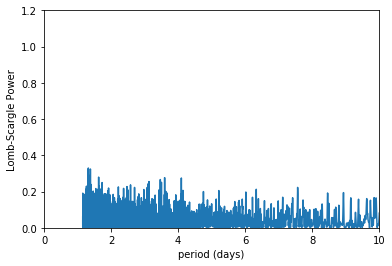

('actualperiod', 0.6666666666666666, 'measured period', 0.013775844616278735, 1.1506398937931026) 150
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


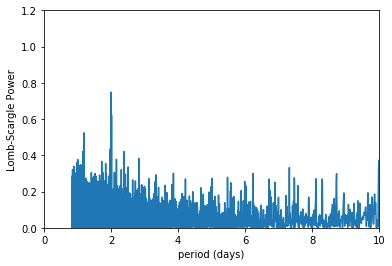

('actualperiod', 0.6666666666666666, 'measured period', 1.9999942486071474, 0.83410309926829251) 150
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


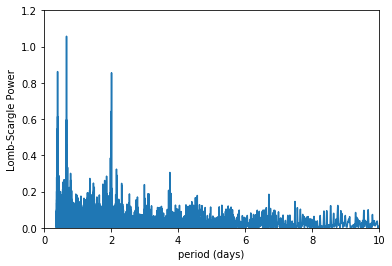

('actualperiod', 0.6666666666666666, 'measured period', 0.66666723516986026, 0.37163740518918909) 150
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


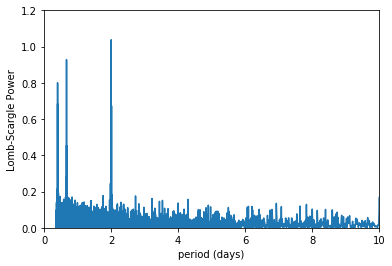

('actualperiod', 0.6666666666666666, 'measured period', 1.9999821367657937, 0.36590236645161317) 150
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


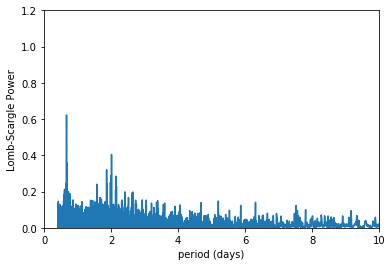

('actualperiod', 0.6666666666666666, 'measured period', 0.66667049453021421, 0.41372401652694546) 150
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


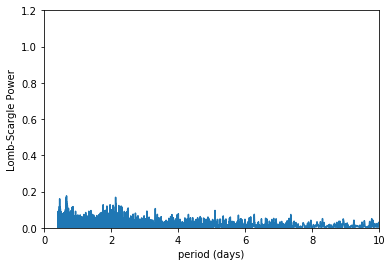

('actualperiod', 0.6666666666666666, 'measured period', 0.66667133651754107, 0.41015243664670648) 150


In [41]:
# actual frequency = frquency/100
lombScargleAuto([150],([23]*7),Nquist=100)
 # 40 background corresponing to R band at new moon, could be made more detailed?

Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


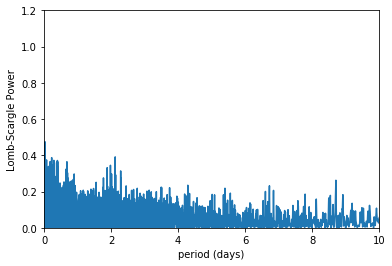

('actualperiod', 0.6666666666666666, 'measured period', 0.023123766828407142, 0.023012797875862051, (0.47474300111208279-0.035688537593364475j))
150


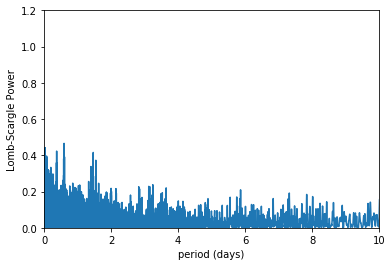

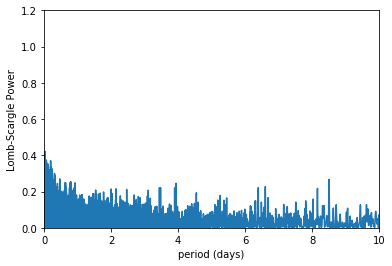

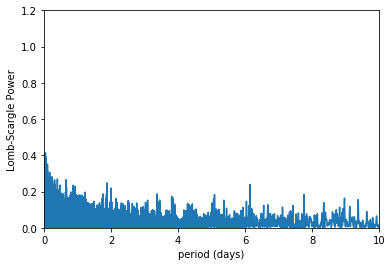

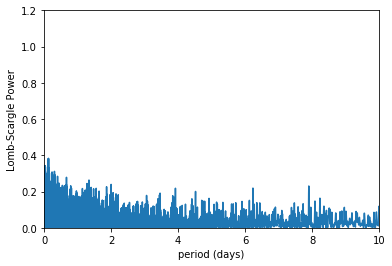

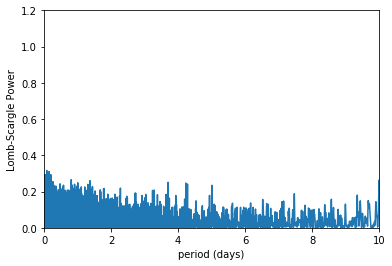

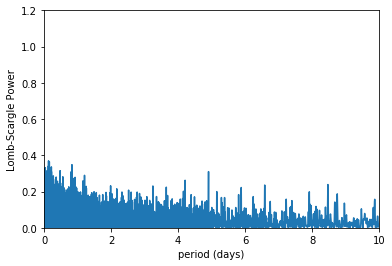

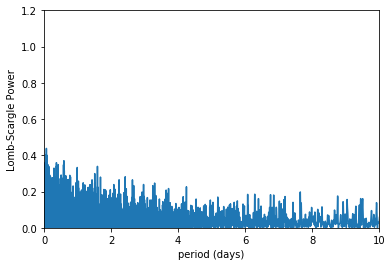

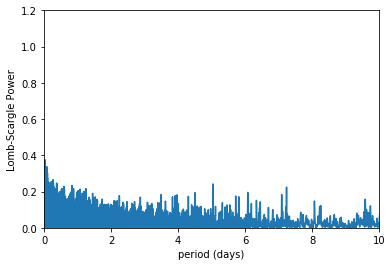

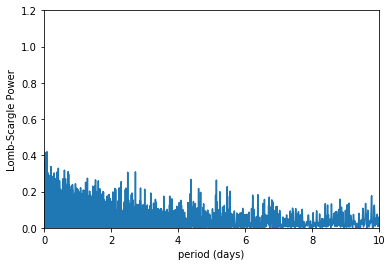

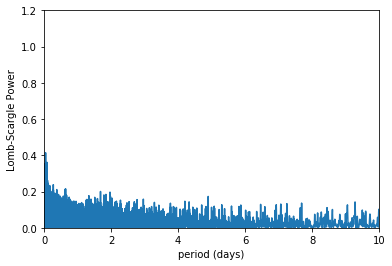

('sig', 1.0, 'counter', 0.0)
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


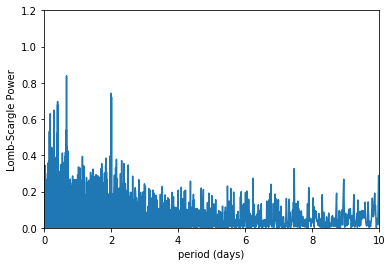

('actualperiod', 0.6666666666666666, 'measured period', 0.6666580620171173, 0.016682061985365849, (0.83880264377171265-0.049258129721140936j))
150


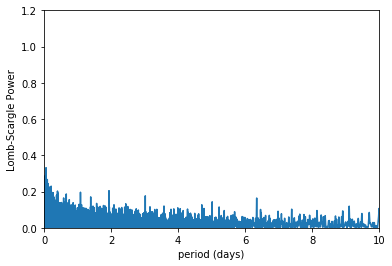

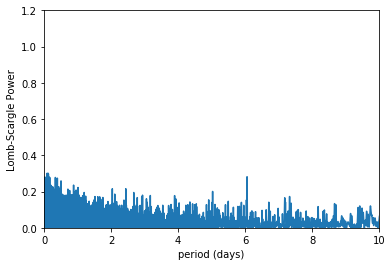

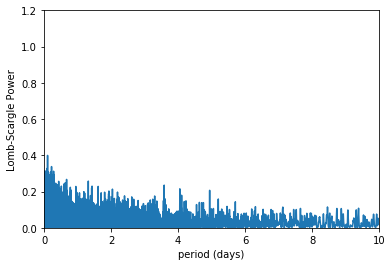

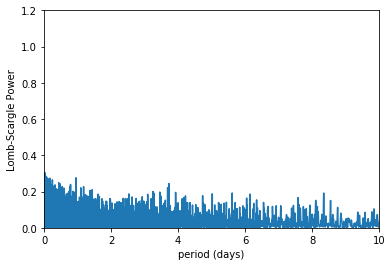

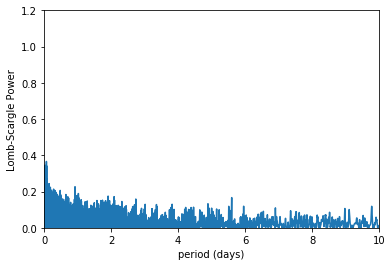

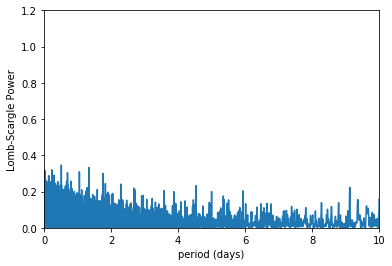

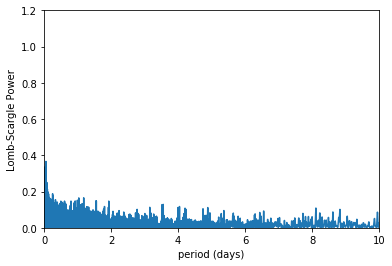

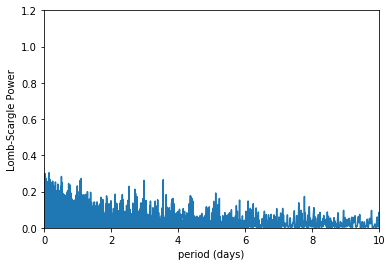

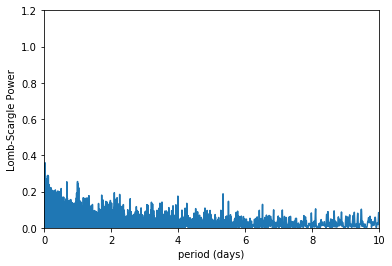

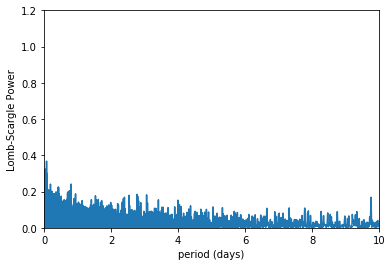

('sig', 1.0, 'counter', 0.0)
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


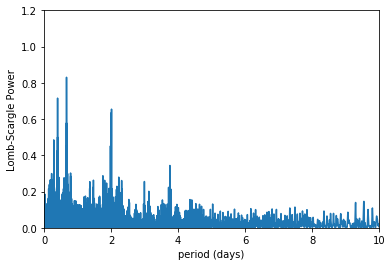

('actualperiod', 0.6666666666666666, 'measured period', 0.6666630979904572, 0.0074327481037837831, (0.83064843565240321-0.017023934217209456j))
150


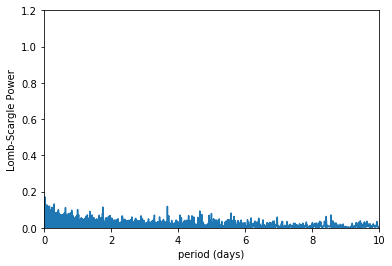

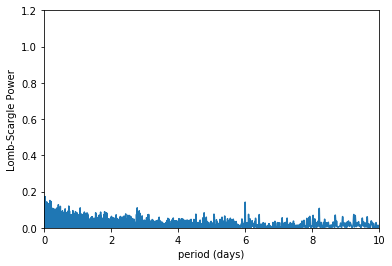

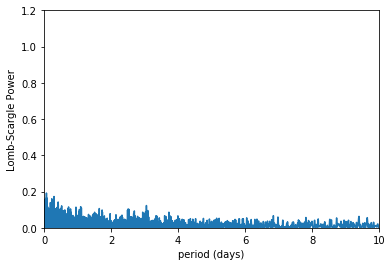

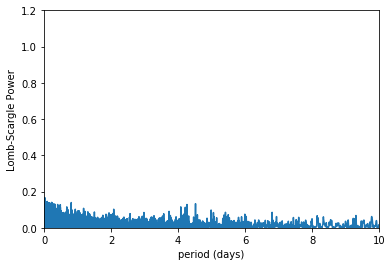

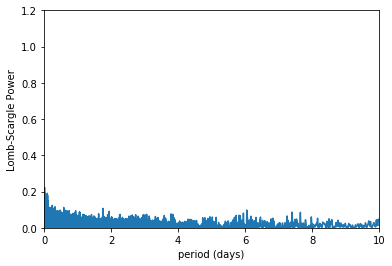

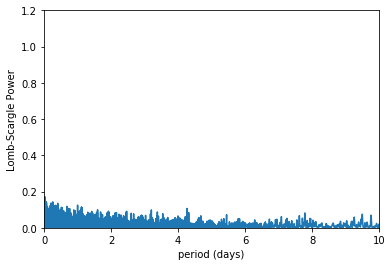

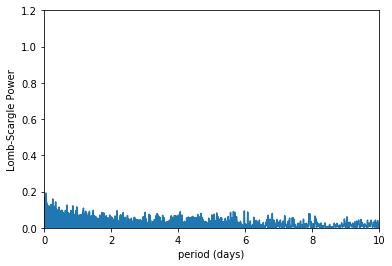

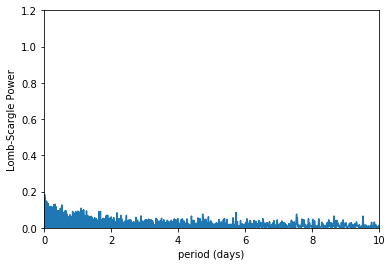

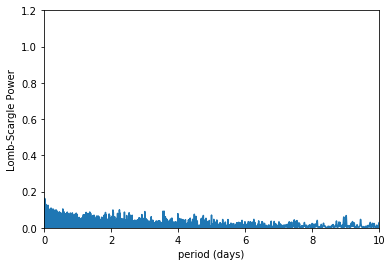

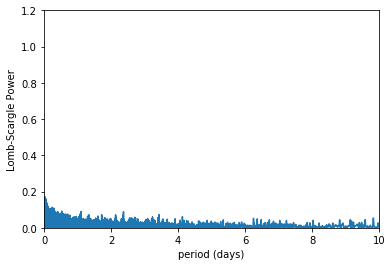

('sig', 1.0, 'counter', 0.0)
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


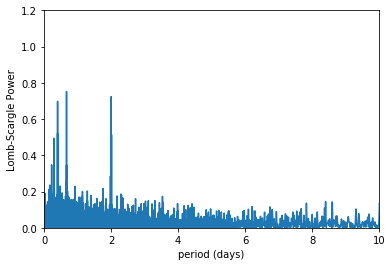

('actualperiod', 0.6666666666666666, 'measured period', 1.9999821367657937, 0.0073180473290322635, (0.75166248103814159+0.05257794046761867j))
150


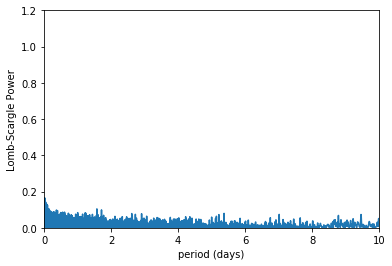

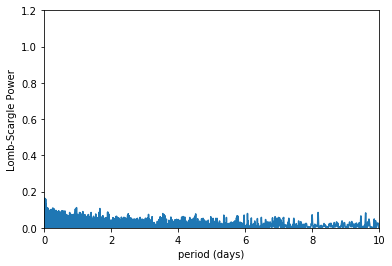

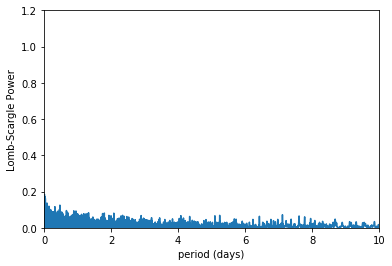

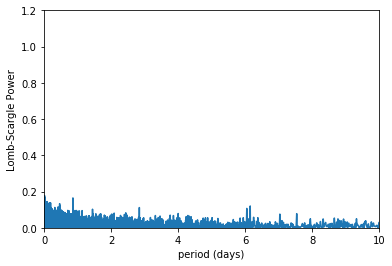

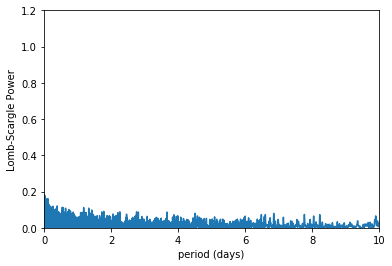

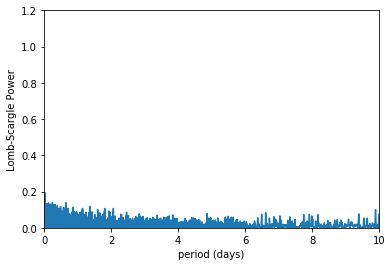

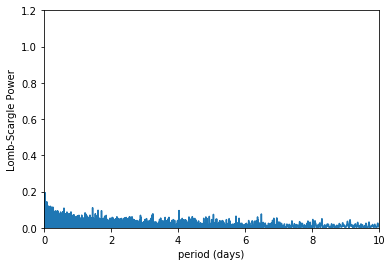

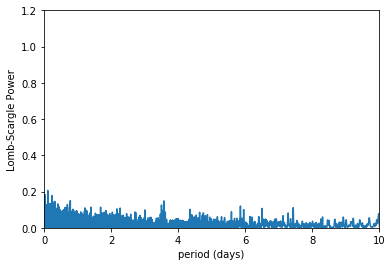

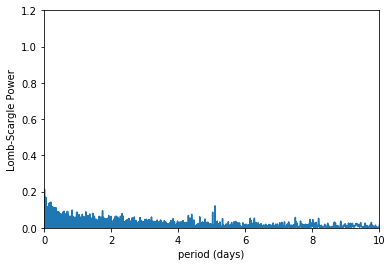

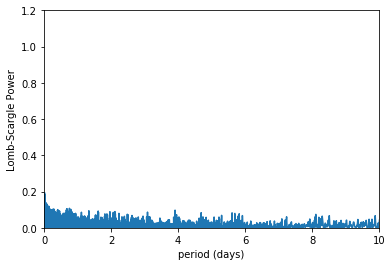

('sig', 1.0, 'counter', 0.0)
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


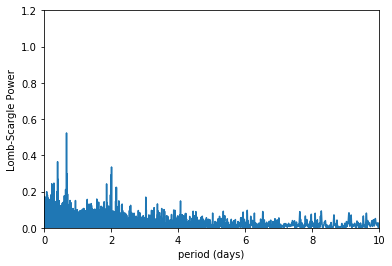

('actualperiod', 0.6666666666666666, 'measured period', 0.66666997991227961, 0.0082744803305389095, (0.52333755148377692+0.012621046804598831j))
150


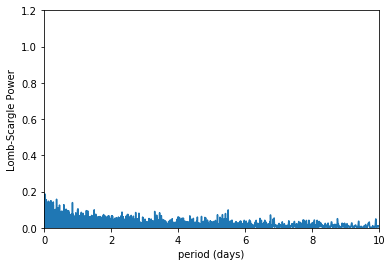

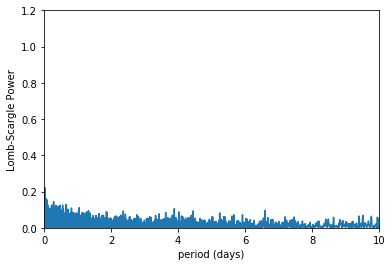

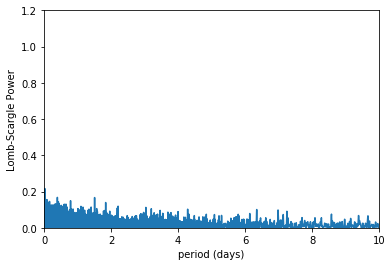

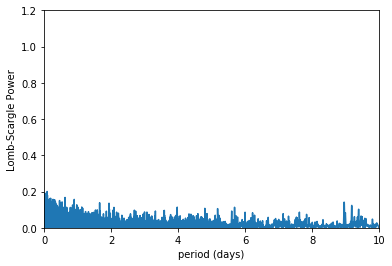

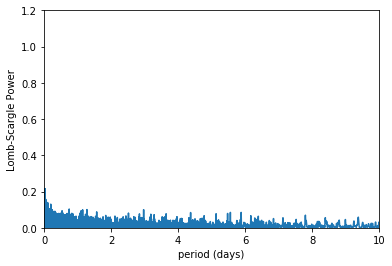

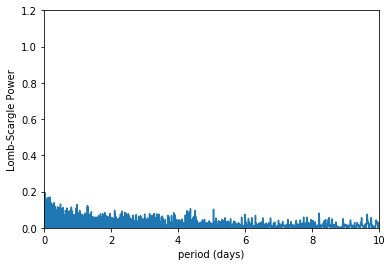

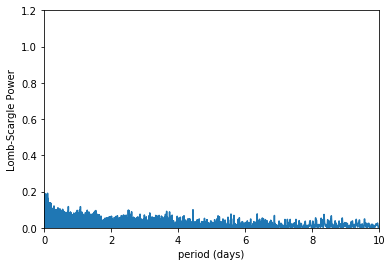

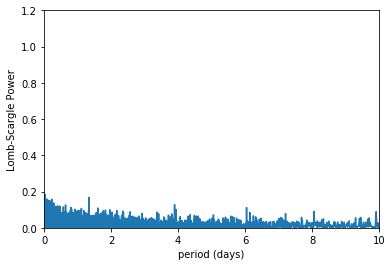

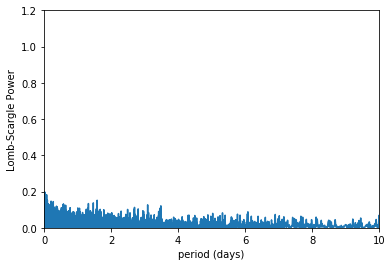

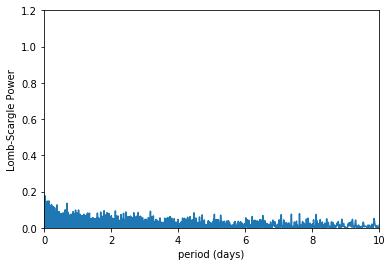

('sig', 1.0, 'counter', 0.0)
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


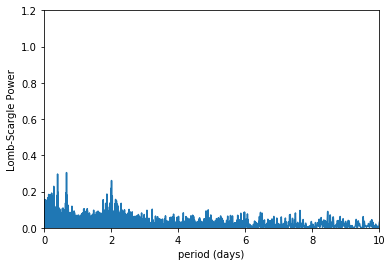

('actualperiod', 0.6666666666666666, 'measured period', 0.66665654247004968, 0.008203048732934131, (0.30474354354701672+0.018169489649652981j))
150


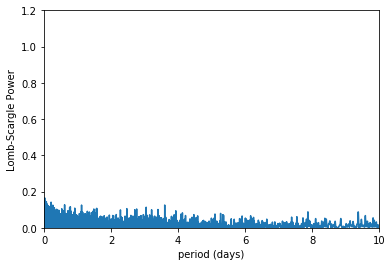

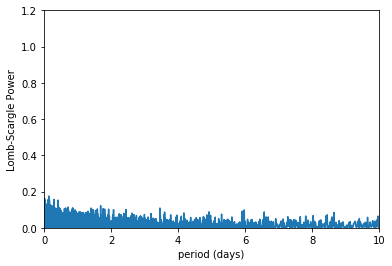

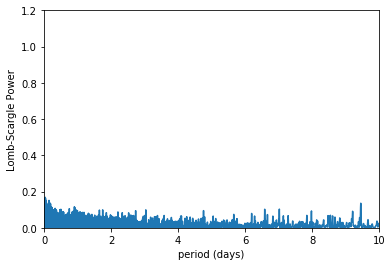

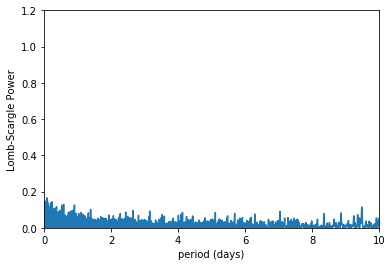

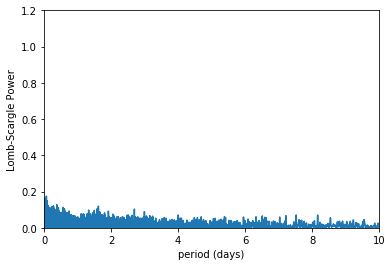

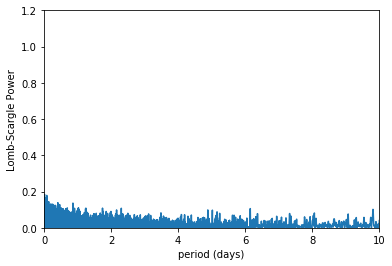

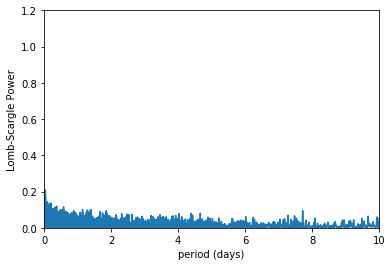

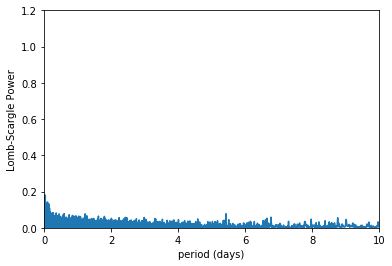

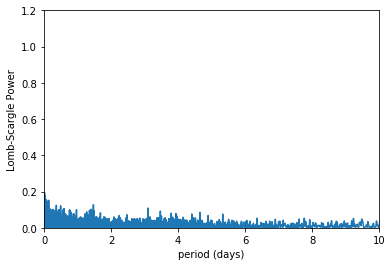

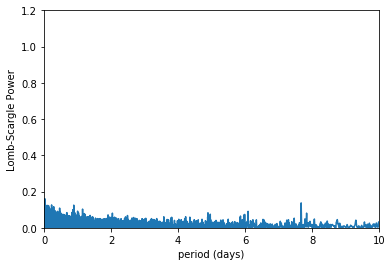

('sig', 1.0, 'counter', 0.0)


In [57]:
lombScargleAuto([150],([23]*7),Nquist=5000,loopNo=10)

Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/gatspy/periodic/optimizer.py:119: ComplexWarning: Casting complex values to real discards the imaginary part
  candidate_scores[i] = score[j]
/home/mj1e16/miniconda2/envs/astroconda/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


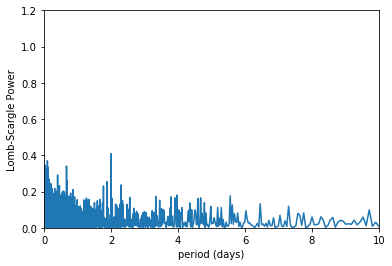

('actualperiod', 0.6666666666666666, 'measured period', 0.11769933608301897, (0.40897878811129595+0.003602104392214556j))
150
('sig', 0.8751, 'counter', 1249.0)
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


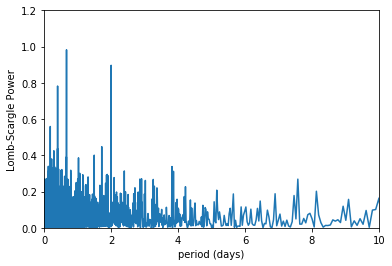

('actualperiod', 0.6666666666666666, 'measured period', 0.666664559975369, (0.98220712292084233-0.054158547299471248j))
150
('sig', 1.0, 'counter', 0.0)
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


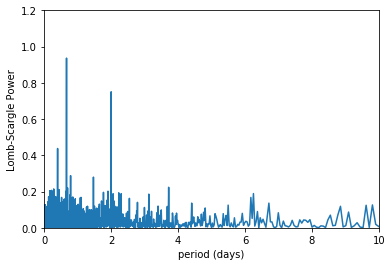

('actualperiod', 0.6666666666666666, 'measured period', 0.66666671801962674, (0.93630233482508907-0.038125811304059648j))
150
('sig', 1.0, 'counter', 0.0)
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


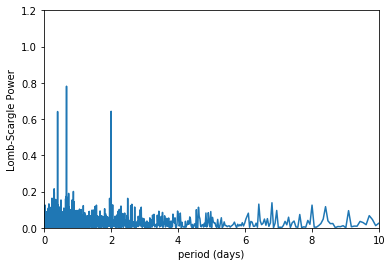

('actualperiod', 0.6666666666666666, 'measured period', 0.66666729504781475, (0.78136389517811655+0.068799487126620831j))
150
('sig', 1.0, 'counter', 0.0)
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


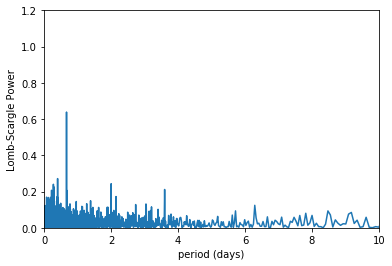

('actualperiod', 0.6666666666666666, 'measured period', 0.66667538344021893, (0.63866419491577686-0.06401829862773642j))
150
('sig', 1.0, 'counter', 0.0)
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


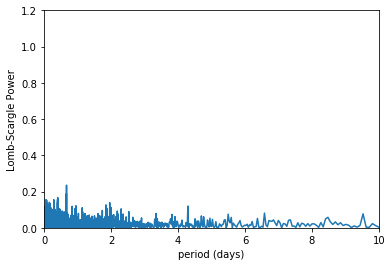

('actualperiod', 0.6666666666666666, 'measured period', 0.66665991649325884, (0.2352322671128553-0.0068047072850159519j))
150
('sig', 0.9996, 'counter', 4.0)


In [14]:
lombScargle([150],([23]*7),numsteps=50000,loopNo=10000)

Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


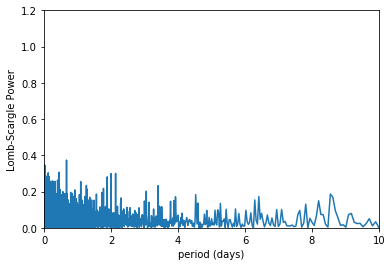

('actualperiod', 0.6666666666666666, 'measured period', 1.9888759708228181, (0.37366341843780115+0.0070628482933948458j))
150


In [ ]:
lombScargle([150],([23]*7),numsteps=100000, loopNo=1000)

In [30]:
lombScargle([150],([23]*7),numsteps=500000)

Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
('actualperiod', 0.6666666666666666, 'measured period', 0.010955773274121046) 150
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
('actualperiod', 0.6666666666666666, 'measured period', 2.0000082844402605) 150
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
('actualperiod', 0.6666666666666666, 'measured period', 0.6

In [31]:
print(totpower)

[[(0.37103071276610977-0.007623479604672404j), (0.83773541049464162-0.029173638067033304j), (0.8090834791685505-0.0081645315951554328j), (0.8215672004901815+0.018707497451986459j), (0.52485677368732031-0.036270648754721427j), (0.30142773718987176-0.0042883206511260272j)]]


In [ ]:
lombScargle([150],([23]*7),numsteps=10000) 

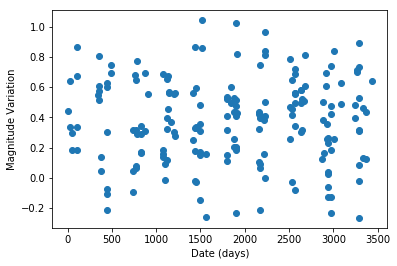

In [137]:
perfex = np.linspace(0, 3500, 3501)
#perfect = [0.1*np.sin((2*np.pi*(frange*0.01))*(x)) for x in perfex]

plt.plot(date, amplitude, 'o')
#plt.plot(perfex, perfect)
plt.ylabel('Magnitude Variation')
plt.xlabel('Date (days)')
#plt.xlim([2200, 2300])
plt.show()

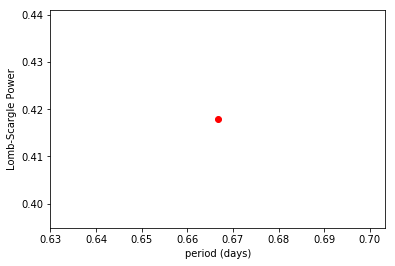

In [138]:
plt.plot(actualperiod, measuredpower)
plt.plot(measuredperiod, measuredpower, 'ro')
plt.xlabel('period (days)')
plt.ylabel('Lomb-Scargle Power')
plt.show()

In [45]:
def over9000(frequencyRange,objectmag,loopNo,modulationAmplitude=0.1,background=40,Nquist=5000,numsteps=20000): # frequency range and object mag in list
    global maxpower, powerperiod
#     powerperiod = []
    maxpower = [] # reset

    for frange in range(0, len(frequencyRange)):    
        allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy = [], [], [], [], [], [], [] #reset
        
        y = [allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy] # for looping only
        for z in range(1, len(y)):
            y[z] = averageFlux(obs[z], frequencyRange[frange], 30)  # amplitde calculation for observations, anf frequency range
        for z in range(1, len(y)):
            y[z] = [modulationAmplitude * t for t in y[z]]
        
        for z in range(1,len(y)):    # loops over number filters
            for G in range(0, len(y[z])): # loops over number of obs
                flareMinute = int((obs[z][G]*24*60)%(1024))
                y[z][G] = y[z][G] + flareMag[flareMinute]
                
        for z in range(3,4):#(1, len(y)):
            date = [x - obs[z][0] for x in obs[z]]
            date = date * u.day
            amplitude = [t+random.gauss(0,magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])) for t in y[z]] # scale amplitude and add poisson noise
            mag = [t + objectmag[z] for t in amplitude]
            error = [sigSys+magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])+0.2]*len(mag) 
            
        for loop in range(0,loopNo):
            random.shuffle(date)
            model = LombScargleFast().fit(date, mag, error)
            periods, power = model.periodogram_auto(nyquist_factor=Nquist)
            model.optimizer.period_range=(0.01, 10)
            maxpower.append(power.max())
#             LSperiod = model.best_period
#             powerperiod.append(LSperiod)
            
    

Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


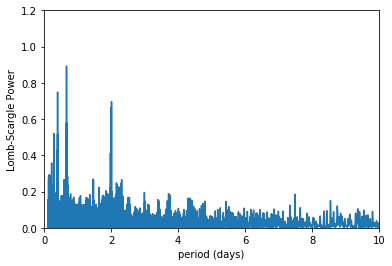

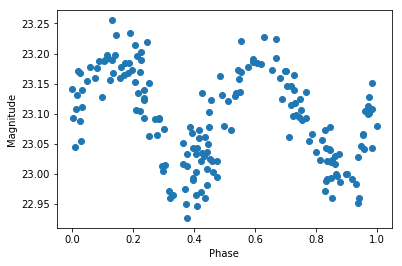

('actualperiod', 0.6666666666666666, 'measured period', 0.6666633565626654) 150
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  

KeyboardInterrupt: 

In [65]:
findObservations([(630,)])
#addsecondExposure()
averageFlux(obs[0], 1, 30)
flaring(-1, 10024, amplitude=0.1)
lombScargle([150],([23]*7),Nquist=300)
over9000([150],([23]*7),10000,Nquist=300)